## Needed Imports

In [ ]:
import random
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import *
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from IPython.display import Image
from keras.applications import vgg16
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, array_to_img
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

## Importing Dataset from Drive (Both train and Test CSV files)

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
#https://drive.google.com/file/d/1aeniAczct5azqfKOJSDB5KOHIbUVcSm2/view?usp=sharing
file_id_1 = '1aeniAczct5azqfKOJSDB5KOHIbUVcSm2'
downloaded = drive.CreateFile({'id': file_id_1})
downloaded.GetContentFile('sign_mnist_train.csv')

In [ ]:
#https://drive.google.com/file/d/1NENt4nt5r5lIoOxh4SflGnVjLpr8pYr4/view?usp=sharing
file_id_2 = '1NENt4nt5r5lIoOxh4SflGnVjLpr8pYr4'
downloaded = drive.CreateFile({'id': file_id_2})
downloaded.GetContentFile('sign_mnist_test.csv')

## Loading  Train and Test CSV files into dataframes  & Defining classes

In [ ]:
train = pd.read_csv('/content/sign_mnist_train.csv')
test = pd.read_csv('/content/sign_mnist_test.csv')


In [ ]:
print(train.shape)
print(test.shape)

(27455, 785)
(7172, 785)


In [ ]:
train_set = np.array(train, dtype = 'float32')
test_set = np.array(test, dtype='float32')

In [ ]:
#Specifying class labels
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y' ]

## Visualizing some samples

(-0.5, 27.5, 27.5, -0.5)

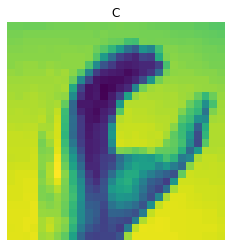

In [ ]:
#See a random image for class label verification
i = random.randint(1,27455)
plt.imshow(train_set[i,1:].reshape((28,28))) 
plt.imshow(train_set[i,1:].reshape((28,28))) 
label_index = train["label"][i]
plt.title(f"{class_names[label_index]}")
plt.axis('off')

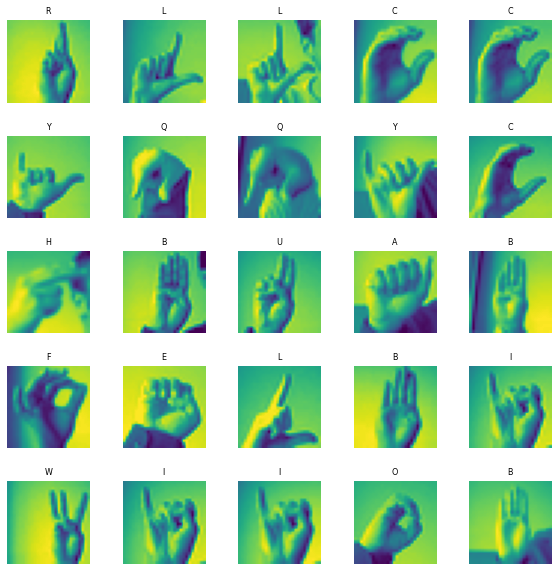

In [ ]:
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5
fig, axes = plt.subplots(L_grid, W_grid, figsize = (10,10))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_train = len(train_set) # get the length of the train dataset
# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 
    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow( train_set[index,1:].reshape((28,28)) )
    label_index = int(train_set[index,0])
    axes[i].set_title(class_names[label_index], fontsize = 8)
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

## Normalizing values to make CNN converge faster


In [ ]:
# Prepare the training and testing dataset 
X_train = train_set[:, 1:] /255
y_train = train_set[:, 0]

X_test = test_set[:, 1:]  /255
y_test = test_set[:,0]

In [ ]:
X_test

array([[0.58431375, 0.58431375, 0.5882353 , ..., 0.4392157 , 0.47058824,
        0.41960785],
       [0.49411765, 0.5019608 , 0.5137255 , ..., 0.72156864, 0.7137255 ,
        0.7058824 ],
       [0.33333334, 0.34509805, 0.36078432, ..., 0.88235295, 0.8784314 ,
        0.87058824],
       ...,
       [0.74509805, 0.7490196 , 0.74509805, ..., 0.827451  , 0.81960785,
        0.8156863 ],
       [0.7882353 , 0.8039216 , 0.8156863 , ..., 0.2627451 , 0.27450982,
        0.24705882],
       [0.6784314 , 0.68235296, 0.6784314 , ..., 0.7647059 , 0.75686276,
        0.7529412 ]], dtype=float32)

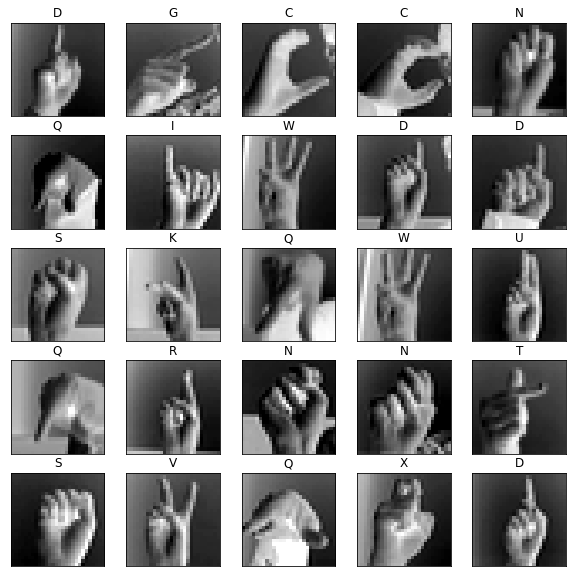

In [ ]:
#Visualize train images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape((28,28)), cmap=plt.cm.binary)
    label_index = int(y_train[i])
    plt.title(class_names[label_index])
plt.show()

## Spliting trainig data into training and validations sets

In [ ]:
#Split the training and test sets
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.1, random_state = 12345)

In [ ]:
print(X_train.shape)
print(y_train.shape)


(24709, 784)
(24709,)


## Defining the model and training

In [ ]:
# Unpack the training and test tuple
HEIGHT = 64
WIDTH = 64
X_train = X_train.reshape(X_train.shape[0], *(28, 28, 1))
X_test = X_test.reshape(X_test.shape[0], *(28, 28, 1))
X_validate = X_validate.reshape(X_validate.shape[0], *(28, 28, 1))

print(X_train.shape)
print(y_train.shape)
print(X_validate.shape)


(24709, 28, 28, 1)
(24709,)
(2746, 28, 28, 1)


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

#Defining the Convolutional Neural Network
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), input_shape = (28,28,1),strides=2, activation='relu'))

cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(32, (3, 3),strides=2, activation='relu'))

cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(32, (3, 3),strides=2, activation='relu'))

cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())

cnn_model.add(Dense(units = 512, activation = 'relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(units = 25, activation = 'softmax'))

In [ ]:
#CNN Model Summary
cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 13, 13, 32)        320       
_________________________________________________________________
dropout_32 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
dropout_33 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 2, 2, 32)          9248      
_________________________________________________________________
dropout_34 (Dropout)         (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 128)              

In [ ]:
#chk_point = tf.keras.callbacks.ModelCheckpoint(filepath='model/cnn_model.{epoch:02d}-{val_loss:.4f}.h5',save_best_only=True),
#ton = tf.keras.callbacks.TerminateOnNaN()

In [ ]:
#Compiling
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer='adam' ,metrics =['accuracy'])

#Training the CNN model
history = cnn_model.fit(X_train, y_train, batch_size = 3 , epochs = 15, verbose = 1, validation_data = (X_validate, y_validate))

Epoch 1/15
8237/8237 [==============================] - 27s 3ms/step - loss: 2.0921 - accuracy: 0.3450 - val_loss: 0.3735 - val_accuracy: 0.8798
Epoch 2/15
8237/8237 [==============================] - 25s 3ms/step - loss: 0.6412 - accuracy: 0.7789 - val_loss: 0.1141 - val_accuracy: 0.9727
Epoch 3/15
8237/8237 [==============================] - 25s 3ms/step - loss: 0.4282 - accuracy: 0.8510 - val_loss: 0.0649 - val_accuracy: 0.9854
Epoch 4/15
8237/8237 [==============================] - 25s 3ms/step - loss: 0.3490 - accuracy: 0.8803 - val_loss: 0.0388 - val_accuracy: 0.9945
Epoch 5/15
8237/8237 [==============================] - 26s 3ms/step - loss: 0.3179 - accuracy: 0.8997 - val_loss: 0.0187 - val_accuracy: 0.9993
Epoch 6/15
8237/8237 [==============================] - 26s 3ms/step - loss: 0.2800 - accuracy: 0.9065 - val_loss: 0.0123 - val_accuracy: 0.9971
Epoch 7/15
8237/8237 [==============================] - 26s 3ms/step - loss: 0.2582 - accuracy: 0.9143 - val_loss: 0.0131 - val_ac

In [ ]:
cnn_model.save('cnn_mnst_DS.h5',save_format="h5")

Text(0.5, 1.0, 'Accuracy evolution')

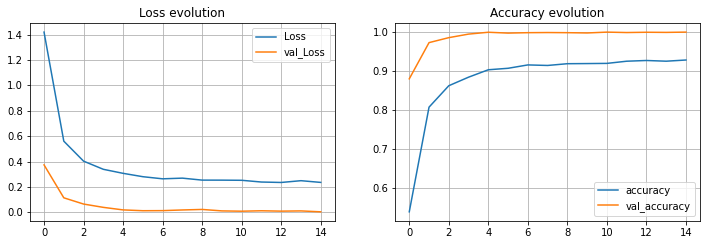

In [ ]:
#Visualizing the training performance
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

In [ ]:
#Predictions for the test data
predicted_classes = cnn_model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


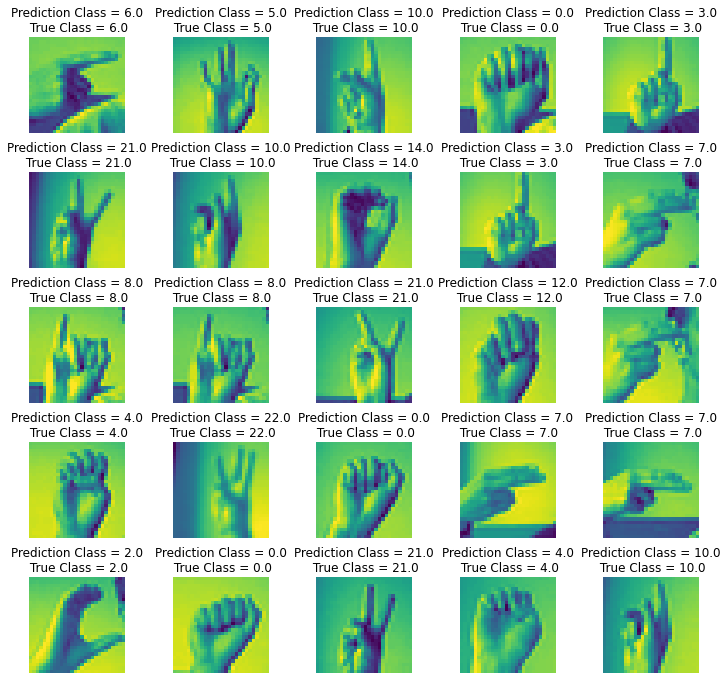

In [ ]:
#Visualize predictions
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i].reshape(28,28))
    axes[i].set_title(f"Prediction Class = {predicted_classes[i]:0.1f}\n True Class = {y_test[i]:0.1f}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## Testing 

In [292]:
from tensorflow import keras
cnn_model = keras.models.load_model('/content/cnn_mnst_DS (1).h5')

In [293]:
import cv2
import numpy as np 
Test_a_image = cv2.imread('/content/test_r.jpg')
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y' ]

In [294]:
from skimage.transform import resize

Test_a_image = resize(Test_a_image, (28,28,1))
print(Test_a_image.shape)


(28, 28, 1)


In [295]:
Test_a_image = np.array(Test_a_image , dtype='float32')  
#Test_a_image

In [296]:
#Test_a_image = Test_a_image 
#Test_a_image

In [297]:
Test_a_image = Test_a_image.reshape(1,28,28,1)
print(Test_a_image.shape)

(1, 28, 28, 1)


In [298]:
pred_label = cnn_model.predict_classes(Test_a_image)
print(pred_label)
class_names[int(pred_label)]

[17]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'R'

## References 


https://www.kaggle.com/datamunge/sign-language-mnist

https://analyticsindiamag.com/
hands-on-guide-to-sign-language-classification-using-cnn/